In [46]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from model import UNET
from dataloader import get_loaders_masks
import FILE_PATHS
import pandas as pd
import joblib

from training_masks import(
    train, 
    plot_loss_curves
)

In [2]:
# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
NUM_EPOCHS = 3
NUM_WORKERS = 4
IMAGE_HEIGHT = 112
IMAGE_WIDTH = 112
PIN_MEMORY = True
LOAD_MODEL = False



In [3]:
# Transformations
train_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        # A.Rotate(limit=35, p=1.0),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

In [4]:
# MODEL
model = UNET(in_channels=3, out_channels=1).to(DEVICE)

# Assign higher weight to positive class (when the pixel is 1)
positive_weight = 2
negative_weight = 1

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model_type = "masks"

In [5]:
# BATCHES
train_loader, val_loader = get_loaders_masks(
    FILE_PATHS.IMAGES,
    FILE_PATHS.MASKS,
    BATCH_SIZE,
    train_transforms,
    val_transforms,
    NUM_WORKERS,
    test_size=0.2,
    seed=42,
)

TRAIN PATHS LENGTHS: images, masks
1599, 1599
VALIDATION PATHS LENGTHS: images, masks
400, 400


In [6]:
model_0_results = train(model=model, 
                        train_dataloader=train_loader,
                        test_dataloader=val_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        device=DEVICE)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5643 | train_acc: 0.7605 | test_loss: 0.6063 | test_acc: 0.8986


 33%|███▎      | 1/3 [01:37<03:15, 97.52s/it]

checkpoint saved
Epoch: 2 | train_loss: 0.3566 | train_acc: 0.9789 | test_loss: 0.3683 | test_acc: 0.9758


 67%|██████▋   | 2/3 [03:07<01:32, 92.92s/it]

checkpoint saved
Epoch: 3 | train_loss: 0.3119 | train_acc: 0.9819 | test_loss: 0.3006 | test_acc: 0.9816


100%|██████████| 3/3 [04:36<00:00, 92.02s/it]

checkpoint saved


In [48]:
filename = "../EchoNet-Dynamic/models/mask_model.joblib"

In [49]:
model_state_dict = model.state_dict()

# Save the model using joblib
joblib.dump(model_state_dict, filename)


['../EchoNet-Dynamic/models/mask_model.joblib']

In [21]:
torch.save(model.state_dict(), filename)

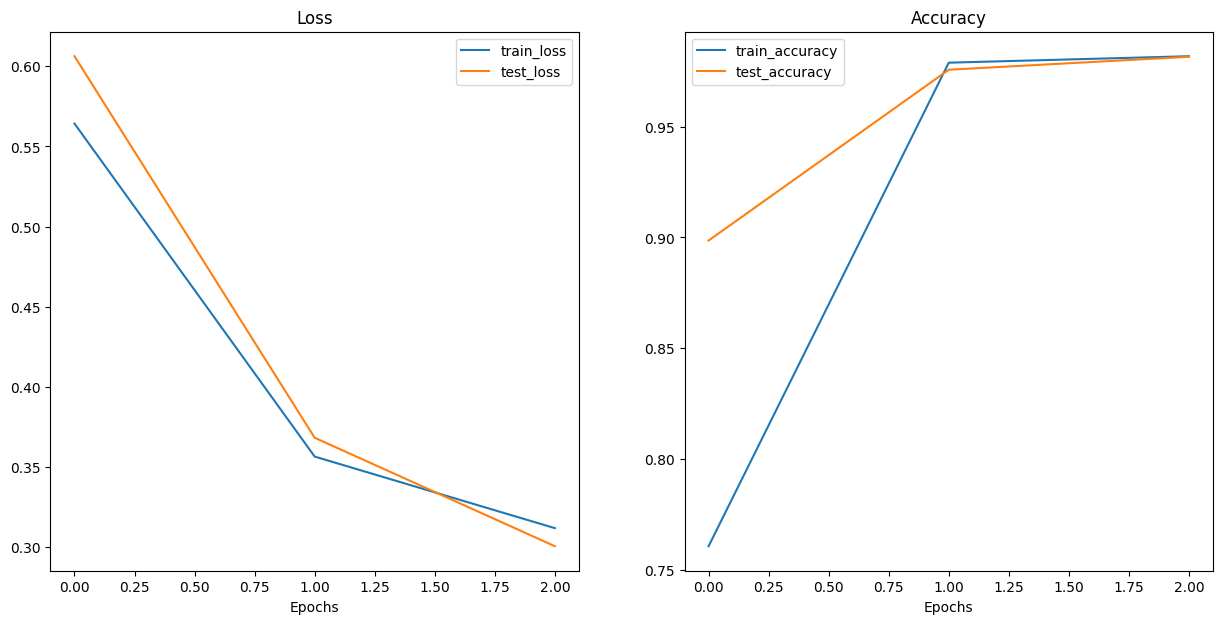

In [7]:
plot_loss_curves(model_0_results)

In [8]:
mask_model = pd.DataFrame(model_0_results)
mask_model.to_csv("mask_model.csv")

In [50]:
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import FILE_PATHS
from model import UNET

In [51]:
def read_video_and_predict(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get the frames per second (fps) of the video
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Calculate the time interval between frames
    frame_interval_ms = int(1000 / fps)

    # Initialize a variable to keep track of the current frame number
    frames_list = []
    predictions_list = []
    current_frame = 0

    # Loop through the video frames
    while True:
        # Set the video's position to the current frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

        # Read the frame
        ret, frame = cap.read()

        # Check if the frame was successfully read
        if not ret:
            break

        frames_list.append(frame)
        """
        # Display the frame using matplotlib
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {current_frame}")
        plt.show()
        """

        # Increment the current frame number based on the frame interval
        current_frame += 1

    # Release the video capture object
    cap.release()

    return frames_list, predictions_list

In [66]:
videos_path = f"{FILE_PATHS.NEW_DATA}"
videos_filesnames = os.listdir(videos_path)
sample_vid_path = f"{videos_path}/{videos_filesnames[2]}"
#sample_vid_path = "../EchoNet-Dynamic/videos/0X1A0A263B22CCD966.avi"

In [67]:
frames_list, predictions_list = read_video_and_predict(sample_vid_path)

In [68]:
frame = frames_list[0]
frame = cv2.resize(frame, (112, 112))
frame = frame / 255.0
frame = np.array(frame)
frame_sample = frame

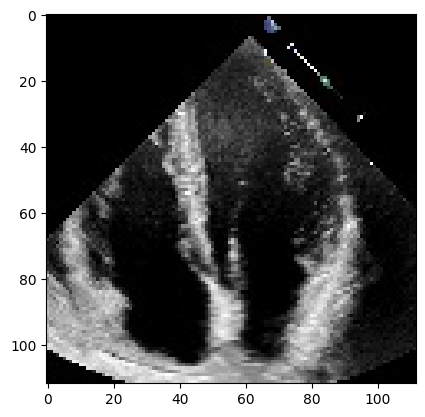

In [69]:
plt.imshow(frame)
plt.show()

In [70]:
frame = frames_list[0]
frame = cv2.resize(frame, (112, 112))
frame = np.array(frame)
frame = torch.from_numpy(frame)
frame = frame.to(DEVICE)
frame = frame.permute(2, 1, 0)
frame = frame.unsqueeze(0)
frame = frame.float()

In [71]:
pred = None
with torch.inference_mode():
    pred_tensor = torch.sigmoid(model(frame))

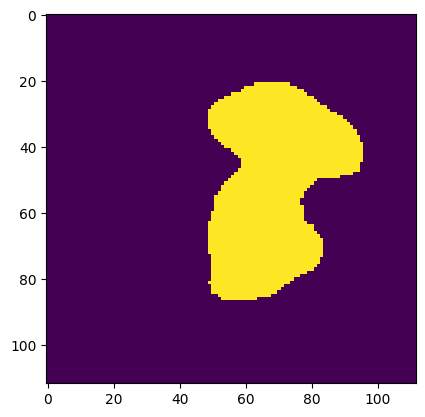

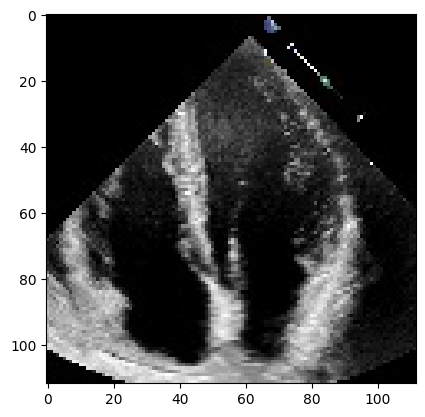

In [72]:
pred = pred_tensor.squeeze(0)
pred = pred.squeeze(0)
pred.shape
pred = pred.to("cpu").numpy()
pred = (pred >= 0.5)
plt.imshow(pred)
plt.show()

plt.imshow(frame_sample)
plt.show()